In [2]:

import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable

from utility_functions.utils import * #read_data, read_press, getnearpos, folder_files, headspace
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
rc['font.family'] = 'sans-serif'
rc['font.sans-serif'] = ['Verdana']



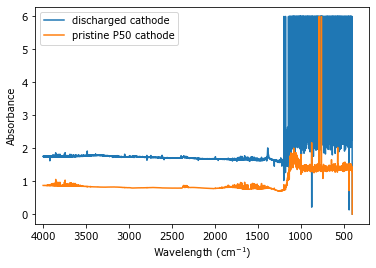

In [2]:
ftir = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/FTIR/210720_Mg_O2_cathode/210720_pristine_p50_carbon_2.CSV', names = ['wavelength', 'absorbance'])

p50disch = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/FTIR/210720_Mg_O2_cathode/210720_mgo2_p50_2mAhdischarge.CSV', names = ['wavelength', 'absorbance'])

fig,ax = plt.subplots()
ax.plot(p50disch['wavelength'], p50disch['absorbance'], label ='discharged cathode')
ax.plot(ftir['wavelength'], ftir['absorbance'], label = 'pristine P50 cathode')

ax.set_xlim(4100, 200)
ax.set_xlabel('Wavelength (cm$^{-1}$)')
ax.set_ylabel('Absorbance')
plt.legend()


In [16]:
def plot_cycle(disch, chrg, press, channel, style=None, n=None, leg=''):
    color= 'xkcd:ocean blue'
    if n==None:
        n=2
#     color='#045a8d'
#     color='xkcd:cerulean'
    #find currents for charge and discharge and //normalize by area
    disc_i= np.mean(disch['I/mA']) #/(np.pi*0.6**2)
    chrg_i= np.mean(chrg['I/mA']) #/(np.pi*0.6**2)
    print('discharge current (mA): ' +str(disc_i))
    #find the final capacity reached on discharge in mAh
    cap=disch['Capacity/mA.h'].iloc[-1]
    if style ==None:
        style = 'solid'
        
    x1=disch['Capacity/mA.h'] #/(np.pi*0.6**2)
    y1=disch['Ewe/V']
    
    x2=(cap-chrg['Capacity/mA.h']) #/(np.pi*0.6**2)
    y2=chrg['Ewe/V']
    
    fig, ax= plt.subplots( figsize=(7,5))
    ax2 = ax.twinx()
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)
    
    ax.plot(x1, y1, c=color, linestyle=style, label=leg, linewidth=2)
    if (str(disch) != str(chrg)):
        ax.plot(x2, y2, c=color, linestyle=style, label='', linewidth=2)
    
    st1=disch['time/s'].iloc[0]
    end1=disch['time/s'].iloc[-1]
    
    st2=chrg['time/s'].iloc[0]
    end2=chrg['time/s'].iloc[-1]
    
    #determine start and end indices in pressure df for discharge and charge
    st_p1 = getnearpos(press['time/s'],st1)
    end_p1 = getnearpos(press['time/s'],end1)
    
    st_p2 = getnearpos(press['time/s'],st2)
    end_p2 = getnearpos(press['time/s'],end2)
    
    temp = press['temperature/C']+273
    umoles = press['pressure/torr']/760*headspace(channel)/temp/0.082057
    umoles = umoles-umoles.iloc[st_p1]
    elec_oxy= x1.iloc[-1]*3.6/96485/umoles[end_p1]
    
    leak_time = np.array(press['time/s'].iloc[5:st_p1-2])
    leak_umol = np.array(umoles.iloc[5:st_p1-2])
    leak_umol = leak_umol- leak_umol[0]
    m, b = np.polyfit(leak_time,leak_umol, 1)
    #plt.figure()
    #plt.plot(leak_time/60, (m*leak_time + b), 'k--', label = 'line of best fit')
    #plt.plot(press['time/s']/60, umoles)
    m = round(m, 5)
    disch_time_min = round((disch['time/s'].iloc[-1]- disch['time/s'].iloc[0])/60, 5)
    
    print( 'pressure change rate is: ' + str(m*60) + ' umoles/min so over the duration of discharge ('\
          + str(disch_time_min) + ' min), ' + str( m*60*disch_time_min) + ' umoles of gas were consumed through side process' )
    x=[0,cap] #/(np.pi*0.6**2)]
    y=[0,-cap*3.6/n/96485*10**6]
    
    print( y[1], ' umoles gas expected to be consumed')
    
    disch_cap=(press['time/s']-press['time/s'].iloc[st_p1])*-disc_i/3600
    char_cap=cap -(press['time/s']-press['time/s'].iloc[st_p2])*chrg_i/3600 #divide cap by/(np.pi*.6**2)

    gap= umoles[end_p1]-umoles[st_p2]
    print((disch_cap.iloc[-1]*3.6/96485/(umoles[end_p1]*10**(-6))))
    line1, = ax2.plot(x, y, 'k-' , label= str(n)+' e$^-$/O$_2$',linewidth= 2, linestyle = '--')
    ax2.plot(disch_cap[st_p1:end_p1+1], (umoles)[st_p1:end_p1+1], 'o', color='#001933', label='discharge', linewidth=3, markevery=(0.0,0.02))# (0,(6,6))) # color '#9E0003' '#ec7014'
    if (str(disch) != str(chrg)):
        ax2.plot(char_cap[st_p2:end_p2+1], (umoles)[st_p2:end_p2+1]+gap, 'o', mfc='white', color='#001933', label='charge', linewidth=3, markevery=(0.0,0.02))# (0,(6,6)))
    
    print("o2 consumed: "+ str(umoles[st_p1]-(umoles[end_p1+1] )))
    print("o2 evolved: "+ str(umoles[end_p2]-(umoles[st_p2+1] )))
    print((umoles[end_p2]-(umoles[st_p2+1]))/(umoles[st_p1]-(umoles[end_p1+1])))

    epermol_c = cap * 3.6 / 96485 *10**6 / (umoles[end_p2-1]-(umoles[st_p2+1]))
    epermol_d = cap * 3.6 / 96485 *10**6 / (umoles[st_p1]-(umoles[end_p1+1]))
    
    #slope_c, int_c = np.polyfit(char_cap[st_p2:end_p2], umoles[st_p2:end_p2], 1)
    #epermol_c = 1/(slope_c/3.6*96485/10**6)
    #slope_dis, int_dis = np.polyfit(disch_cap[st_p1:end_p1], umoles[st_p1:end_p1], 1)
    #epermol_d = -1/(slope_dis/3.6*96485/10**6)
    
    ax2.legend(fontsize=14)
    ax.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', color=color, fontsize=20)
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax2.set_ylabel('n$_{gas}$ ($\mu$mol)', fontsize=20)
    plt.tight_layout()
    #ax.set_ylim([0,3.5])
    
    print('e per mol on discharge = ' + str(epermol_d))
    #print('e per mol on charge = ' + str(epermol_c))
    
    return 

discharge current (mA): -0.500025731741683
pressure change rate is: 0.0042 umoles/min so over the duration of discharge (95.15211 min), 0.39963886199999993 umoles of gas were consumed through side process
-14.794755613346103  umoles gas expected to be consumed
-2.4985667658039223
o2 consumed: 13.303249550905633
o2 evolved: -13.131765679059313
-0.9871096252693654
e per mol on discharge = 2.224231840007682


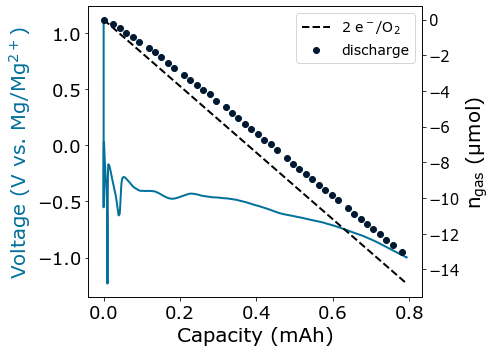

In [17]:

MgOtf2_MgCl2_press = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210924_Mg_O2_MgCl2-MgOTf2-DME_discharge/210924_Mg_O2_MgCl2-MgOTf2-DME_discharge_Ch4__2021-09-24_12.25_13.txt')
MgOtf2_MgCl2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210924_Mg_O2_MgCl2-MgOTf2-DME_discharge/')
plot_cycle(MgOtf2_MgCl2[1], MgOtf2_MgCl2[1], MgOtf2_MgCl2_press, 4)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210924_Mg_O2_MgCl2-MgOTf2-DME_discharge/210924_Mg_O2_MgCl2-MgOTf2-DME_discharge.png', transparent = True, dpi=600, bbox_inches='tight')



9.327874799191584

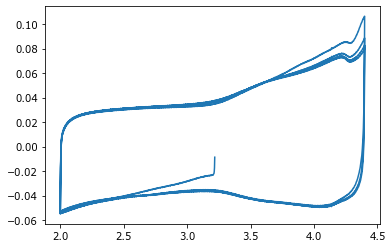

In [8]:
dme_stability = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180302_1MLiTFSI_DME_P50_underAr/')
plt.figure()
plt.plot(dme_stability[1]['Ewe/V'], dme_stability[1]['<I>/mA'])